PORCENTAJE DE POBLACIÓN DE 18 AÑOS Y MÁS QUE CONFÍA EN EL GOBIERNO DE LA CDMX

In [1]:
rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,showtext)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

Cargando paquete requerido: pacman

Warning message:
"package 'pacman' was built under R version 4.4.2"



rlang    (1.1.5 -> 1.1.6) [CRAN]
cli      (3.6.4 -> 3.6.5) [CRAN]
magrittr (2.0.3 -> 2.0.4) [CRAN]
tibble   (3.2.1 -> 3.3.0) [CRAN]
ggplot2  (3.5.1 -> 4.0.0) [CRAN]


Installing 5 packages: rlang, cli, magrittr, tibble, ggplot2

Warning message:
"packages 'tibble', 'ggplot2' are in use and will not be installed"
Installing packages into 'C:/Users/ipdp_/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\ipdp_\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\ipdp_\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\ipdp_\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\ipdp_\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"


package 'magrittr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'magrittr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\ipdp_\AppData\Local\R\win-library\4.4\00LOCK\magrittr\libs\x64\magrittr.dll  a C:\Users\ipdp_\AppData\Local\R\win-library\4.4\magrittr\libs\x64\magrittr.dll: Permission denied"
Warning message:
"restored 'magrittr'"



The downloaded binary packages are in
	C:\Users\ipdp_\AppData\Local\Temp\RtmpsNqMM2\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────



Please download and install Rtools 4.4 from https://cran.r-project.org/bin/windows/Rtools/.



* checking for file 'C:\Users\ipdp_\AppData\Local\Temp\RtmpsNqMM2\remotes38344b7661bb\cpyp-ipdp-funcionespgd-6fd64b9/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/ipdp_/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
font_add_google("Poppins", "pop")
showtext_auto()

In [3]:
dir.create("data", showWarnings = FALSE)

In [4]:
url_encig_basica<-"https://www.inegi.org.mx/contenidos/programas/encig/"
segunda_parte<-"microdatos/encig"
years_encig<-c("2017","2019","2021", "2023")

In [5]:
# Descargar los archivos, descomprimirlos y renombrarlos
options(timeout=10000)
for (i in 1:length(years_encig)) {
  # Ajustar el sufijo de la URL y archivo según el año
  if (years_encig[i] %in% c("2017", "2019")) {
    fin <- "_base_datos_dbf.zip"
  } else {
    fin <- "_base_datos_csv.zip"
  }

  # Construir la URL y el nombre del archivo destino
  url <- paste0(url_encig_basica, years_encig[i], "/", segunda_parte, str_sub(years_encig[i], 3, 4), fin)
  print(url)
  destfile <- paste0("data/encig", str_sub(years_encig[i], 3, 4), fin)

   # Solo descargar si no existe
  if (!file.exists(destfile)) {
    message("Descargando archivo para el año ", years_encig[i], "...")
    download.file(url, destfile = destfile)
    unzip(destfile, exdir = "data")
  } else {
    message("Archivo ya existe: ", destfile)
  }
}

[1] "https://www.inegi.org.mx/contenidos/programas/encig/2017/microdatos/encig17_base_datos_dbf.zip"


Archivo ya existe: data/encig17_base_datos_dbf.zip



[1] "https://www.inegi.org.mx/contenidos/programas/encig/2019/microdatos/encig19_base_datos_dbf.zip"


Archivo ya existe: data/encig19_base_datos_dbf.zip



[1] "https://www.inegi.org.mx/contenidos/programas/encig/2021/microdatos/encig21_base_datos_csv.zip"


Archivo ya existe: data/encig21_base_datos_csv.zip



[1] "https://www.inegi.org.mx/contenidos/programas/encig/2023/microdatos/encig23_base_datos_csv.zip"


Archivo ya existe: data/encig23_base_datos_csv.zip



In [6]:
# Función de estimación
process_files <- function(years, variable) {
  # Función anidada para estimar el indicador
  estima_indicador <- function(path, variable) {
    # Extraer el año del archivo
    year <- substr(path, 11, 14)

    # Leer los datos y hacer las transformaciones necesarias de las variables
    if (year %in% c("2017", "2019")) {
      datos <- foreign::read.dbf(path) %>%
        janitor::clean_names() %>%
        mutate(p11_1_6 = if ("p11_1_6" %in% names(.)) as.numeric(p11_1_6) else as.numeric(p3_2),
               fac_p18 = as.numeric(fac_p18),
               upm = as.numeric(upm),
               est_dis = as.numeric(est_dis)) %>%
        # Filtrar Ciudad de México
        filter(ent == "09")
    } else if (year %in% c("2021", "2023")) {
      datos <- read_csv(path, show_col_types = FALSE) %>%
        janitor::clean_names() %>%
        rename_with(~ ifelse(. == "p11_1_06", "p11_1_6", .)) %>%
        # Filtrar Ciudad de México
        filter(nom_ent == "CIUDAD DE MEXICO")
    } else {
      stop("Año no soportado.")
    }

    # Diseño muestral
    dm <- datos %>%
      as_survey_design(ids = upm, strata = est_dis, weights = fac_p18)

    # Confianza
    if (variable == "confianza") {
      confianza_gob <- dm %>%
        mutate(confianza = case_when(
          p11_1_6 == 1 | p11_1_6 == 2 ~ "Confía",
          TRUE ~ "No confía"
        )) %>%
        group_by(confianza) %>%
        summarise(
          personas = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
        # Filtrar confianza
        filter(confianza == "Confía") %>%
        mutate(porcentaje = round(porcentaje * 100, 2),
               year = year)
      return(confianza_gob)

      # Actos de corrupción
    } else if (variable == "actos_corrupcion") {
      actos_corrup <- dm %>%
        mutate(actos_corrupcion = case_when(
          p3_2 == 1 | p3_2 == 2 ~ "Frecuentes",
          TRUE ~ "No frecuentes"
        )) %>%
        group_by(actos_corrupcion) %>%
        summarise(
          personas = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
        filter(actos_corrupcion == "Frecuentes") %>%
        mutate(porcentaje = round(porcentaje * 100, 2),
               year = year)
      return(actos_corrup)

    } else {
      stop("Variable no reconocida.")
    }
  }

  map_dfr(years, function(year) {
    # Seleccionar el archivo correcto según la variable y el año
    file_path <- if (variable == "actos_corrupcion") {
      if (year %in% c(2017, 2019)) {
        paste0("data/encig", year, "_01_sec1_3_4_5_8_9_10.dbf")
      } else if (year %in% c(2021, 2023)) {
        paste0("data/encig", year, "_01_sec1_A_3_4_5_8_9_10.csv")
      } else {
        stop("Año no soportado para actos de corrupción.")
      }
    } else if (variable == "confianza") {
      if (year %in% c(2017, 2019)) {
        paste0("data/encig", year, "_01_sec_11.dbf")
      } else if (year %in% c(2021, 2023)) {
        paste0("data/encig", year, "_01_sec_11.csv")
      } else {
        stop("Año no soportado para confianza.")
      }
    } else {
      stop("Variable no reconocida.")
    }

    # Print del archivo que se está procesando
    print(paste("Procesando archivo:", file_path))

    # Invocar la función de estimación
    estima_indicador(file_path, variable)
  })
}


In [7]:
# Estimar indicadores de gobierno
tabla_confianza<-process_files(years_encig, variable = "confianza")
print("Porcentaje de personas que confían en el gobierno de la Ciudad de México")
tabla_confianza

[1] "Procesando archivo: data/encig2017_01_sec_11.dbf"
[1] "Procesando archivo: data/encig2019_01_sec_11.dbf"
[1] "Procesando archivo: data/encig2021_01_sec_11.csv"


New names:
• `` -> `...1`


[1] "Procesando archivo: data/encig2023_01_sec_11.csv"


New names:
• `` -> `...1`


[1] "Porcentaje de personas que confían en el gobierno de la Ciudad de México"


confianza,personas,personas_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Confía,1241859,0.05099752,14.16,0.04852940,2017
Confía,2836364,0.02448298,40.87,0.02166087,2019
Confía,3351823,0.02201146,48.17,0.01892866,2021
Confía,3446410,0.02412965,45.49,0.01937280,2023


Proyecciones y Escenarios

In [8]:
# Timeout y repositorio
options(timeout = 600)
options(repos = c(CRAN = 'https://cran.rstudio.com/'))

# Instalar paquetería necesaria para trabajar con fuentes
install.packages(c('sysfonts', 'showtext'))

if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, ggplot2, janitor, srvyr, sysfonts, showtext)

Warning message:
"packages 'sysfonts', 'showtext' are in use and will not be installed"


In [9]:
# Asegurar formato
tabla_confianza <- tabla_confianza %>%
  mutate(year = as.numeric(year),
         porcentaje = as.numeric(porcentaje)) %>%
  arrange(year)

# Año base = último año observado
ano_base <- max(tabla_confianza$year)

# --- Interpolar la serie histórica año a año (para tener línea continua similar a tu plantilla) ---
# Esto convierte los puntos 2017,2019,2021,2023 en valores para cada año 2017:2023
years_hist <- seq(min(tabla_confianza$year), ano_base, by = 1)
interp <- approx(x = tabla_confianza$year,
                 y = tabla_confianza$porcentaje,
                 xout = years_hist, method = "linear", ties = mean)
hist_df <- data.frame(ciclo = interp$x, Deseable = round(interp$y, 2))

# Valor base (2023)
valor_base <- hist_df$Deseable[hist_df$ciclo == ano_base]

# Definir metas relativas para 2045 (automático: +10%, +20%, +30% sobre valor_base)
inercial_2045      <- valor_base * 1.10
deseable_2045      <- valor_base * 1.20
transformador_2045 <- valor_base * 1.30

# Periodo futuro anual (incluye ano_base para continuidad)
fut_years <- seq(ano_base, 2045, by = 1)
n_fut <- length(fut_years)  # incluye 2023..2045

# Construir df_final con misma estructura que en tu script original (ciclo, Deseable, Inercial, Transformador)
df_future <- data.frame(
  ciclo = fut_years,
  Deseable = seq(valor_base, deseable_2045, length.out = n_fut),
  Inercial = seq(valor_base, inercial_2045, length.out = n_fut),
  Transformador = seq(valor_base, transformador_2045, length.out = n_fut)
)

# Unir historia (hasta 2023) y futuro (2023..2045)
# Para que no haya duplicados y 2023 sea idéntico en ambos, construiremos df_final así:
#  - historia sin 2023, luego todo df_future (que contiene 2023..2045)
hist_no_base <- hist_df %>% filter(ciclo < ano_base) %>%
  mutate(Inercial = NA_real_, Transformador = NA_real_) %>%
  select(ciclo, Deseable, Inercial, Transformador)

df_final <- bind_rows(
  hist_no_base,
  df_future
)

# Asegurar que 2023 tenga el mismo valor en las 3 columnas
df_final$Deseable[df_final$ciclo == ano_base] <- valor_base
df_final$Inercial[df_final$ciclo == ano_base] <- valor_base
df_final$Transformador[df_final$ciclo == ano_base] <- valor_base

# Redondear a 2 decimales (como tu template)
df_final[, -1] <- round(df_final[, -1], 2)

# Verificar
print(df_final)

   ciclo Deseable Inercial Transformador
1   2017    14.16       NA            NA
2   2018    27.52       NA            NA
3   2019    40.87       NA            NA
4   2020    44.52       NA            NA
5   2021    48.17       NA            NA
6   2022    46.83       NA            NA
7   2023    45.49    45.49         45.49
8   2024    45.90    45.70         46.11
9   2025    46.32    45.90         46.73
10  2026    46.73    46.11         47.35
11  2027    47.14    46.32         47.97
12  2028    47.56    46.52         48.59
13  2029    47.97    46.73         49.21
14  2030    48.38    46.94         49.83
15  2031    48.80    47.14         50.45
16  2032    49.21    47.35         51.07
17  2033    49.63    47.56         51.69
18  2034    50.04    47.76         52.31
19  2035    50.45    47.97         52.93
20  2036    50.87    48.18         53.55
21  2037    51.28    48.38         54.17
22  2038    51.69    48.59         54.79
23  2039    52.11    48.80         55.42
24  2040    52.5

In [10]:
#El dataframe debe contener las columnas: ciclo, Deseable, Inercial, Transformador

obs <- df_final %>% #observado
filter(ciclo <= ano_base)

fut <- df_final %>% #escenarios futuros
filter(ciclo >= ano_base)

GRAFICO: Porcentaje de personas que confían en el gobierno de la Ciudad de México

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'roboto' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'roboto' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'roboto' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'roboto' not found, will use 'sans' instead"
Warning message in grid.Call(C_stringMetric, as.gr

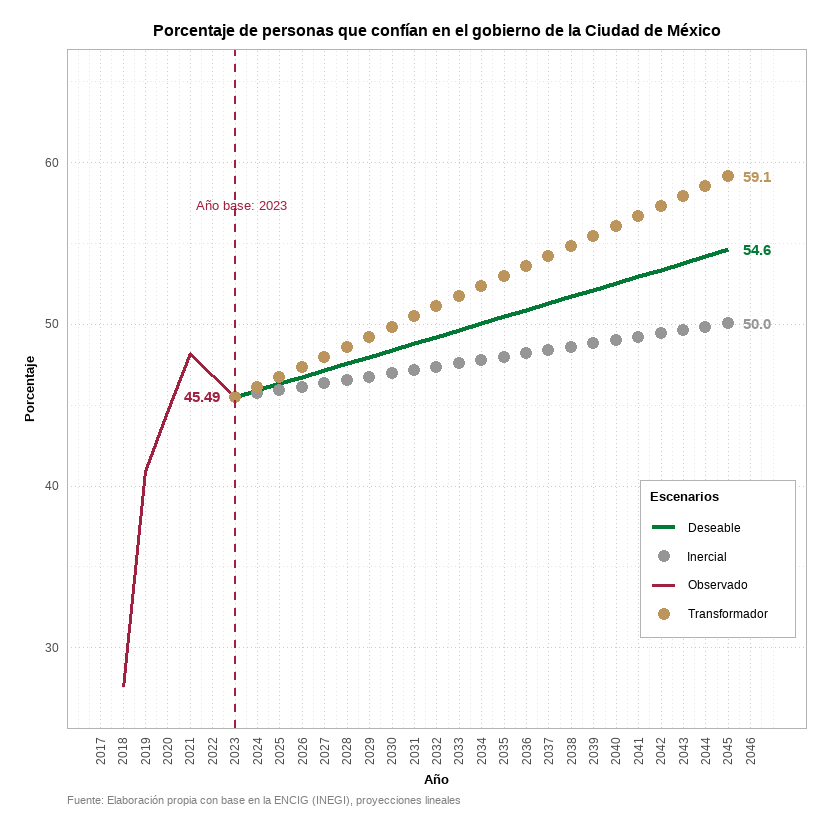

In [11]:
p <- ggplot() +
  
  # Observado
  geom_line(data = obs, aes(x = ciclo, y = Deseable, color = "Observado"), linewidth = 1.1) +
  
  # Deseable
  geom_line(data = fut, aes(x = ciclo, y = Deseable, color = "Deseable"), linewidth = 1.25) +
  
  # Escenarios futuros
  geom_point(data = fut, aes(x = ciclo, y = Inercial, color = "Inercial"), size = 3) +
  geom_point(data = fut, aes(x = ciclo, y = Transformador, color = "Transformador"), size = 3) +
  
  # Línea vertical del año base
  geom_vline(xintercept = ano_base, color = "#9F2241", linetype = "dashed", linewidth = 0.7) +
  annotate("text", x = ano_base + 0.3, y = max(df_final$Deseable) * 1.05,
           label = paste("Año base:", ano_base),
           color = "#9F2241", size = 3.3, family = "roboto") +
  
  # Etiqueta base
  annotate("text", x = ano_base - 1.5, y = df_final$Deseable[df_final$ciclo == ano_base],
           label = sprintf("%.2f", df_final$Deseable[df_final$ciclo == ano_base]),
           color = "#9F2241", size = 4, fontface = "bold", family = "roboto") +
  
  # Etiquetas finales flotantes
  annotate("text", x = 2046.3, y = df_final$Deseable[df_final$ciclo == 2045],
           label = sprintf("%.1f", df_final$Deseable[df_final$ciclo == 2045]),
           color = "#027a35", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_final$Inercial[df_final$ciclo == 2045],
           label = sprintf("%.1f", df_final$Inercial[df_final$ciclo == 2045]),
           color = "#969696", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_final$Transformador[df_final$ciclo == 2045],
           label = sprintf("%.1f", df_final$Transformador[df_final$ciclo == 2045]),
           color = "#BC955C", size = 4, fontface = "bold", family = "roboto") +
  
  # Títulos y ejes
  labs(
    title = "Porcentaje de personas que confían en el gobierno de la Ciudad de México",
    x = "Año",
    y = "Porcentaje",
    color = "Escenarios",
    caption = "Fuente: Elaboración propia con base en la ENCIG (INEGI), proyecciones lineales"
  ) +
  
  # Escalas
  scale_y_continuous(limits = c(25, 65), expand = expansion(mult = c(0, 0.05))) +
  scale_x_continuous(breaks = seq(2017, 2046, 1), limits = c(2017, 2047)) +
  
  # Colores
  scale_color_manual(values = c(
    "Observado" = "#9F2241",
    "Deseable" = "#027a35",
    "Inercial" = "#969696",
    "Transformador" = "#BC955C"
  )) +
  
  # Tema con cuadrícula más visible
  theme_minimal(base_family = "roboto") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(size = 10, face = "bold"),
    axis.text = element_text(size = 9),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    
    # 🔹 Aquí el cambio principal: cuadrícula más visible
    panel.grid.major = element_line(color = "gray80", linetype = "dotted", linewidth = 0.5),
    panel.grid.minor = element_line(color = "gray90", linetype = "dotted", linewidth = 0.3),
    
    # Resto del formato
    plot.caption = element_text(hjust = 0, size = 8, color = "gray50"),
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.position = c(0.88, 0.25),
    legend.background = element_rect(fill = "white", color = "gray70", size = 0.3),
    legend.key = element_rect(fill = "white", color = NA),
    panel.border = element_rect(color = "gray70", fill = NA, linewidth = 0.5),  # contorno
    plot.margin = margin(15, 20, 20, 15)
  )

print(p)